# Проект PoC: Поиск изображений по описанию

## Постановка задачи

**Компания**: фотохостинг «Со Смыслом» (With Sense)

**📌 Цель проекта**<br>
Разработка демонстрационной версии поиска изображений по текстовому запросу.  
Пользователь вводит описание сцены — сервис находит подходящие фотографии на основе текстово-визуального соответствия.

**🔐 Юридические ограничения**<br>
В странах присутствия сервиса действуют законы, запрещающие показывать изображения, связанные с детьми младше 16 лет, без разрешения родителей.  
В рабочем сервисе при таких нарушениях выводится сообщение:

> **This image is unavailable in your country in compliance with local laws.**

В рамках PoC функционал фильтрации отсутствует, поэтому:
- Перед обучением необходимо **очистить датасет** от потенциально проблемного контента;
- Во время тестов — при наличии "вредного" текста в запросе — **выводить дисклеймер вместо результата**.



**🧾 Описание данных**

**📁 Обучающая выборка**
**`train_dataset.csv`** — описание изображений:
- `image`: имя файла изображения  
- `query_id`: ID описания (`<image_name>#<index>`)  
- `query_text`: текст описания  

Каждое изображение может иметь до 5 текстов.  
**`train_images/`** — изображения для обучения.



**🧠 Аннотации соответствия**
**`CrowdAnnotations.tsv`** — оценки соответствия текста и изображения по мнению пользователей:
- имя изображения  
- query_id  
- доля положительных отзывов  
- количество "да"  
- количество "нет"

**`ExpertAnnotations.tsv`** — оценки соответствия от экспертов:
- имя изображения  
- query_id  
- оценки 3 экспертов по шкале от 1 до 4



**🧪 Тестовая выборка**
**`test_queries.csv`** — текстовые запросы:
- query_id  
- query_text  
- релевантное изображение  

**`test_images/`** — изображения для тестирования



**🛠️ Условия реализации**
- Для построения модели использовать только **один фреймворк**: PyTorch или Keras  
- На выходе модель должна выдавать **оценку от 0 до 1**, показывающую, насколько хорошо изображение соответствует запросу

**📋 План работы**
- Загрузка данных и проведение исследовательского анализа данных (EDA)
- Подготовка данных к обучению модели
- Обучение модели на обучающей выборке
- Тестирование модели и демонстрация примеров её работы
- Общий вывод по результатам работы и оценка перспективы интеграции в продукт

## Импорт библиотек и настройка тетрадки

In [1]:
# 1. Стандартные библиотеки
import os
import time

# 2. Научные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 3. Визуализация
from PIL import Image
from IPython.display import display

# 4. Torch & Vision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights

# 5. Transformers (HuggingFace)
from transformers import BertTokenizer, BertModel

# 6. Scikit-learn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    GroupShuffleSplit,
    RandomizedSearchCV,
    ParameterGrid
)
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import (
    mean_squared_error, r2_score
)
from sklearn.linear_model import (
    Ridge, Lasso
)
from sklearn.ensemble import (
    RandomForestRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

# 9. Прочее
from tqdm.notebook import tqdm  # для Jupyter

## Загрузка данных

In [2]:
train = pd.read_csv('train_dataset.csv')

In [3]:
test = pd.read_csv('test_queries.csv', sep='|')

In [4]:
crowd_annot = pd.read_csv('CrowdAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'relevance_ratio', 'crowd_votes_match', 'crowd_votes_mismatch'])

In [5]:
expert_annot = pd.read_csv('ExpertAnnotations.tsv', sep='\t', header=None, names=['image', 'query_id', 'expert_1', 'expert_2', 'expert_3'])

In [6]:
display(train.info(), train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [7]:
display(test.info(), test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  500 non-null    int64 
 1   query_id    500 non-null    object
 2   query_text  500 non-null    object
 3   image       500 non-null    object
dtypes: int64(1), object(3)
memory usage: 15.8+ KB


None

,Unnamed: 0,query_id,query_text,image
0,0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


In [8]:
display(crowd_annot.info(), crowd_annot.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   image                 47830 non-null  object 
 1   query_id              47830 non-null  object 
 2   relevance_ratio       47830 non-null  float64
 3   crowd_votes_match     47830 non-null  int64  
 4   crowd_votes_mismatch  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

,image,query_id,relevance_ratio,crowd_votes_match,crowd_votes_mismatch
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [9]:
display(expert_annot.info(), expert_annot.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   expert_1  5822 non-null   int64 
 3   expert_2  5822 non-null   int64 
 4   expert_3  5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


## Исследовательский анализ данных (EDA)

### Отмечаю сообщения про детей

In [10]:
# Шаг 1: найдём строки с "детскими" словами
keywords_mask = train['query_text'].str.contains('child|kid|baby|babies|boy|girl', case=False, na=False)

# Шаг 2: извлечём имена изображений из query_id до символа '#'
images_with_kids = train.loc[keywords_mask, 'query_id'].str.extract(r'^(.*)#')[0].unique()

# Шаг 3: создаём новый столбец 'kids', где True для всех строк с этими изображениями
train['kids'] = train['image'].isin(images_with_kids)

In [11]:
train.sample(3)

,image,query_id,query_text,kids
537,2748729903_3c7c920c4d.jpg,3591458156_f1a9a33918.jpg#2,A man at a rodeo is thrown off a horse .,False
4929,3518126579_e70e0cbb2b.jpg,3518126579_e70e0cbb2b.jpg#2,A young man attempts to ride a unicycle down a...,False
2458,3437654963_c4fdc17e8b.jpg,3263395801_5e4cee2b9e.jpg#2,A motocross bike is being ridden along a woodl...,False


### Аггрегирую оценки экспертов и крауда

**Эксперты**

In [12]:
# Функция для подсчета итоговой оценки
def get_majority_vote(row):
    votes = [row['expert_1'], row['expert_2'], row['expert_3']]
    vote_counts = pd.Series(votes).value_counts()
    
    # Если все оценки разные (встречаются по одному разу), вернуть None
    if vote_counts.iloc[0] == 1:
        return None
    else:
        return vote_counts.idxmax()

In [13]:
# Применяем функцию к строкам и создаём колонку с финальной оценкой
expert_annot['experts_score'] = expert_annot.apply(get_majority_vote, axis=1)

In [14]:
# Удаляем строки, где все оценки разные (т.е. final_score = None)
expert_annot_cleaned = expert_annot.dropna(subset=['experts_score'])

In [15]:
# Масштабируем по максимальной оценке минус 1, чтобы для полного несоотвествия признак был равен нулю
expert_annot_cleaned = expert_annot_cleaned.copy()
expert_annot_cleaned['experts_score'] = expert_annot_cleaned['experts_score'].apply(lambda x: (x-1)/3)

In [16]:
# Результат
expert_annot_cleaned.head()

,image,query_id,expert_1,expert_2,expert_3,experts_score
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.000000
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2,0.000000
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2,0.000000
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2,0.333333
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2,0.000000


**Крауд**

In [17]:
crowd_annot.sample(3)

,image,query_id,relevance_ratio,crowd_votes_match,crowd_votes_mismatch
26171,3159995270_17334ccb5b.jpg,1317292658_ba29330a0b.jpg#2,0.0,0,3
37161,354642192_3b7666a2dd.jpg,1167669558_87a8a467d6.jpg#2,0.0,0,3
42602,424416723_19c56cb365.jpg,3070011270_390e597783.jpg#2,0.0,0,3


In [18]:
crowd_annot.dropna(inplace=True)

**Создаю таргет**

Для тагрета беру - (оценку экспертов - большинство)*0.6+(крауд relevance_ratio)*0.4

In [19]:
expert_annot_cleaned['index'] = expert_annot_cleaned['image'] + expert_annot_cleaned['query_id']
expert_annot_cleaned.head(1)

,image,query_id,expert_1,expert_2,expert_3,experts_score,index
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1,0.0,1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9...


In [20]:
crowd_annot['index'] = crowd_annot['image']+crowd_annot['query_id']
crowd_annot.head(1)

,image,query_id,relevance_ratio,crowd_votes_match,crowd_votes_mismatch,index
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0,1056338697_4f7d7ce270.jpg1056338697_4f7d7ce270...


In [21]:
train['index'] = train['image']+train['query_id']
train.head(1)

,image,query_id,query_text,kids,index
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,False,1056338697_4f7d7ce270.jpg2549968784_39bfbe44f9...


In [22]:
# Объединяем по колонке 'index'
train_merged = train.merge(
    expert_annot_cleaned[['index', 'experts_score']],
    on='index',
    how='left'
).merge(
    crowd_annot[['index', 'relevance_ratio']],
    on='index',
    how='left'
)

In [23]:
# Функция для расчёта target с учетом условий
def calculate_target(row):
    score = row['experts_score']
    ratio = row['relevance_ratio']
    
    if pd.isna(score) and pd.isna(ratio):
        return None
    return (0 if pd.isna(score) else score) * 0.6 + (0 if pd.isna(ratio) else ratio) * 0.4

In [24]:
# Применяем функцию построчно
train_merged['target'] = train_merged.apply(calculate_target, axis=1)

In [25]:
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   image            5822 non-null   object 
 1   query_id         5822 non-null   object 
 2   query_text       5822 non-null   object 
 3   kids             5822 non-null   bool   
 4   index            5822 non-null   object 
 5   experts_score    5696 non-null   float64
 6   relevance_ratio  2329 non-null   float64
 7   target           5767 non-null   float64
dtypes: bool(1), float64(3), object(4)
memory usage: 324.2+ KB


In [26]:
# Убираем лишние столбцы
train_merged.drop(columns=['experts_score', 'relevance_ratio', 'index'], inplace=True)

In [27]:
# Шаг 1: Найдём изображения с детьми
images_with_kids_and_high_target = train_merged.query('kids == True')['image'].unique()

# Шаг 2: Удалим все строки с такими изображениями, а также все строки с kids == True
filtered_df = train_merged[
    (train_merged['kids'] == False) &
    (~train_merged['image'].isin(images_with_kids_and_high_target)) &
    (~train_merged['target'].isna())
].copy()

In [28]:
filtered_df.drop(columns=['kids'], inplace=True)

In [29]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4064 entries, 0 to 5820
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   image       4064 non-null   object 
 1   query_id    4064 non-null   object 
 2   query_text  4064 non-null   object 
 3   target      4064 non-null   float64
dtypes: float64(1), object(3)
memory usage: 158.8+ KB


In [30]:
filtered_df.head(3)

,image,query_id,query_text,target
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0


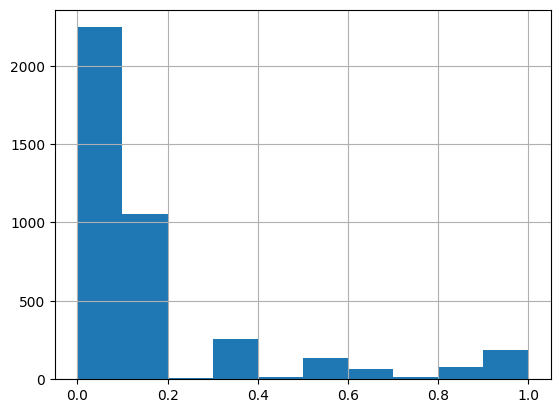

In [31]:
filtered_df['target'].hist();

**Вывод:** 80% пар картинка-запрос имеют низкий таргет по релевантности (до 0.2).

### Печать фотографий тренировочного датасета

In [32]:
def photos_print(df, path_2):
    # Группируем все query_text по каждому изображению
    grouped = df.groupby('image')['query_text'].apply(list).reset_index()

    # Оставим только первые 15 изображений для вывода
    sample = grouped.head(15)

    # Размер вывода
    fig, axes = plt.subplots(len(sample), 1, figsize=(10, len(sample) * 3))

    # Если только 1 изображение — обернём в список
    if len(sample) == 1:
        axes = [axes]

    for i, row in enumerate(sample.itertuples()):
        image_path = os.path.join(path_2, row.image)
        try:
            img = Image.open(image_path).resize((224, 224))
            axes[i].imshow(img)
            axes[i].axis('off')
            # Объединяем все запросы в одну строку
            query_texts = "\n• " + "\n• ".join(row.query_text)
            axes[i].set_title(f"Имя файла: {row.image}\nЗапросы:{query_texts}", fontsize=10)
        except Exception as e:
            print(f"Ошибка при открытии изображения {row.image}: {e}")

    plt.tight_layout()
    plt.show()


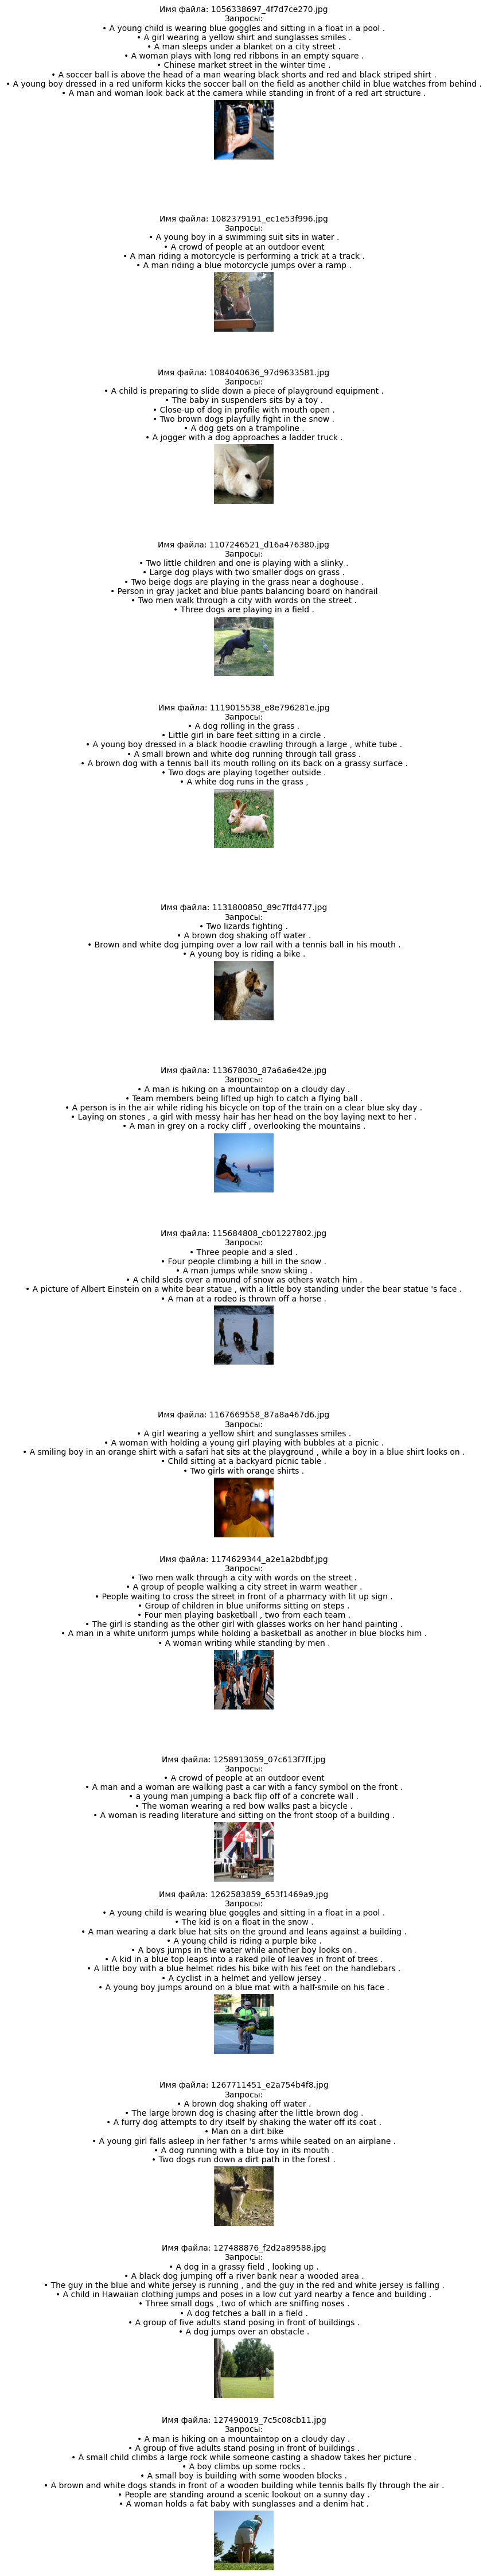

In [33]:
photos_print(filtered_df, 'train_images/')

## Формирую текстовые эмбеддинги (BERT)

In [34]:
def get_bert_text_embeddings(texts, batch_size=64, max_length=512, device=None):
    """
    Вычисляет BERT-эмбеддинги по текстовым строкам.

    Parameters:
        texts (pd.Series or list or str): тексты
        batch_size (int): размер батча
        max_length (int): максимум токенов
        device (str): 'cuda' или 'cpu' (определяется автоматически, если None)

    Returns:
        pd.DataFrame: эмбеддинги + колонка 'index' для merge
    """

    # Приведение к Series
    if isinstance(texts, str):
        texts = pd.Series([texts])
    elif isinstance(texts, list):
        texts = pd.Series(texts)
    elif isinstance(texts, pd.Series):
        texts = texts.copy()
    else:
        raise ValueError("Ожидается строка, список или Series.")

    # Удалим пустые строки и приведем индекс
    texts = texts[texts.notna() & (texts.str.strip() != '')].reset_index(drop=False)
    texts.rename(columns={texts.columns[1]: 'query_text'}, inplace=True)

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    else:
        device = torch.device(device)

    print(f"🔌 Используется устройство: {device}")

    # Инициализация BERT
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    model = BertModel.from_pretrained('bert-base-uncased').to(device)
    model.eval()

    embeddings = []

    # Один tqdm по батчам
    num_batches = (len(texts) + batch_size - 1) // batch_size
    for i in tqdm(range(num_batches), desc="🚀 Обработка BERT батчей"):
        batch = texts.iloc[i * batch_size : (i + 1) * batch_size]
        tokenized = tokenizer(
            batch['query_text'].tolist(),
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        )

        with torch.no_grad():
            output = model(
                input_ids=tokenized['input_ids'].to(device),
                attention_mask=tokenized['attention_mask'].to(device)
            )
            # Суммируем по токенам
            batch_embeddings = output.last_hidden_state.sum(dim=1).cpu().numpy()

        embeddings.append(batch_embeddings)

    all_embeddings = np.concatenate(embeddings)

    df_embeddings = pd.DataFrame(
        all_embeddings,
        columns=[f'txt_feat_{i}' for i in range(all_embeddings.shape[1])]
    )
    df_embeddings['index'] = texts['index'].values

    return df_embeddings


In [35]:
text_embeddings_df = get_bert_text_embeddings(filtered_df['query_text'], batch_size=64)

🔌 Используется устройство: cuda


🚀 Обработка BERT батчей:   0%|          | 0/64 [00:00<?, ?it/s]

In [36]:
text_embeddings_df.shape

(4064, 769)

In [37]:
df_all = filtered_df.reset_index(drop=True).merge(
    text_embeddings_df, left_index=True, right_on='index'
).drop(columns='index')

In [38]:
df_all[['query_text', 'txt_feat_0']].head()

,query_text,txt_feat_0
0,A young child is wearing blue goggles and sitt...,3.755517
1,A young child is wearing blue goggles and sitt...,3.755517
2,A young child is wearing blue goggles and sitt...,3.755517
3,A young child is wearing blue goggles and sitt...,3.755517
4,A young child is wearing blue goggles and sitt...,3.755517


## Формирую эмбеддинги картинок

In [39]:
class SafeImageDataset(Dataset):
    def __init__(self, image_names, image_dir, transform=None):
        self.image_names = image_names
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, image_name)
        try:
            img = Image.open(image_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            return img, image_name
        except Exception as e:
            return None  # пропускаем ошибочные изображения

def collate_fn(batch):
    batch = [b for b in batch if b is not None]
    if not batch:
        return None, None
    images, names = zip(*batch)
    return torch.stack(images), names

def extract_embeddings_resnet50_safe(
    image_names,
    image_dir,
    batch_size: int = 32,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
):
    print(f"📦 Старт: извлекаем эмбеддинги ResNet-50 для {len(image_names)} изображений...")
    start_time = time.time()

    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model = torch.nn.Sequential(*list(model.children())[:-1])
    model.to(device)
    model.eval()

    transform = weights.transforms()
    dataset = SafeImageDataset(image_names, image_dir, transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=collate_fn)

    all_embeddings = []
    all_filenames = []

    for batch_imgs, batch_names in tqdm(loader, desc="🔄 Извлечение эмбеддингов", total=len(loader)):
        if batch_imgs is None:
            continue
        batch_imgs = batch_imgs.to(device)
        with torch.no_grad():
            embeddings = model(batch_imgs).squeeze(-1).squeeze(-1).cpu().numpy()
        all_embeddings.append(embeddings)
        all_filenames.extend(batch_names)

    all_embeddings = np.vstack(all_embeddings)
    df = pd.DataFrame(all_embeddings, columns=[f'img_feat_{i}' for i in range(all_embeddings.shape[1])])
    df.insert(0, 'image', all_filenames)

    elapsed = time.time() - start_time
    print(f"✅ Готово! {len(df)} изображений обработано за {elapsed:.1f} сек.")

    return df


In [40]:
df_img_emb = extract_embeddings_resnet50_safe(
    image_names=filtered_df['image'].unique(),
    image_dir='train_images',
    batch_size=32
)

df_all = df_all.merge(df_img_emb, on='image', how='left')

📦 Старт: извлекаем эмбеддинги ResNet-50 для 712 изображений...


🔄 Извлечение эмбеддингов:   0%|          | 0/23 [00:00<?, ?it/s]

✅ Готово! 712 изображений обработано за 21.2 сек.


In [41]:
# Проверим
print(df_all.shape)
df_all.head()

(2853, 2820)


,image,query_id,query_text,target,txt_feat_0,txt_feat_1,txt_feat_2,txt_feat_3,txt_feat_4,txt_feat_5,...,img_feat_2038,img_feat_2039,img_feat_2040,img_feat_2041,img_feat_2042,img_feat_2043,img_feat_2044,img_feat_2045,img_feat_2046,img_feat_2047
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,...,0.000000,0.000000,0.087660,0.004346,0.00000,0.020302,0.298617,0.151533,0.001071,0.000000
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,...,0.189011,0.289025,0.000000,0.000000,0.00000,0.000000,0.067744,0.724385,0.726659,0.021861
2,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,...,0.000000,0.034942,0.594084,0.044686,0.00000,1.627412,1.368394,0.093920,0.000000,0.077191
3,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,...,0.000000,0.000000,0.013333,0.000000,0.00000,0.054710,0.299946,0.166757,0.000000,0.000000
4,486712504_36be449055.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,...,0.000053,0.000000,0.186343,0.000000,0.16157,0.017576,0.012277,0.000000,0.007313,0.000000


In [42]:
df_all.drop(columns=['query_id', 'query_text'], inplace=True)

## Делаю разбивку на train и test

In [43]:
# Допустим, у тебя датафрейм с колонками: image, query_text, target и т.д.
# Мы хотим, чтобы все строки с одинаковым image попали либо в train, либо в test
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=42)

In [44]:
# Разделение по группам (по изображению)
train_idx, test_idx = next(
    gss.split(X=df_all.drop(columns=['target']), y=df_all['target'], groups=df_all['image'])
)

In [45]:
# Получаем выборки
train_df = df_all.iloc[train_idx].reset_index(drop=True)
test_df = df_all.iloc[test_idx].reset_index(drop=True)

In [46]:
# Проверка — ни одно изображение не должно пересекаться
assert set(train_df['image']).isdisjoint(set(test_df['image'])), "❌ Обнаружено пересечение изображений!"
print(f"✅ Разделение выполнено: {len(train_df)} в train, {len(test_df)} в test")

✅ Разделение выполнено: 1999 в train, 854 в test


In [47]:
train_df.head()

,image,target,txt_feat_0,txt_feat_1,txt_feat_2,txt_feat_3,txt_feat_4,txt_feat_5,txt_feat_6,txt_feat_7,...,img_feat_2038,img_feat_2039,img_feat_2040,img_feat_2041,img_feat_2042,img_feat_2043,img_feat_2044,img_feat_2045,img_feat_2046,img_feat_2047
0,1056338697_4f7d7ce270.jpg,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,1.255375,16.285788,...,0.000000,0.000000,0.087660,0.004346,0.00000,0.020302,0.298617,0.151533,0.001071,0.000000
1,1262583859_653f1469a9.jpg,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,1.255375,16.285788,...,0.189011,0.289025,0.000000,0.000000,0.00000,0.000000,0.067744,0.724385,0.726659,0.021861
2,3222041930_f642f49d28.jpg,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,1.255375,16.285788,...,0.000000,0.034942,0.594084,0.044686,0.00000,1.627412,1.368394,0.093920,0.000000,0.077191
3,3718964174_cb2dc1615e.jpg,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,1.255375,16.285788,...,0.000000,0.000000,0.013333,0.000000,0.00000,0.054710,0.299946,0.166757,0.000000,0.000000
4,486712504_36be449055.jpg,0.0,3.755517,-5.111005,1.083612,5.116993,13.461018,-8.385941,1.255375,16.285788,...,0.000053,0.000000,0.186343,0.000000,0.16157,0.017576,0.012277,0.000000,0.007313,0.000000


In [48]:
test_df.head()

,image,target,txt_feat_0,txt_feat_1,txt_feat_2,txt_feat_3,txt_feat_4,txt_feat_5,txt_feat_6,txt_feat_7,...,img_feat_2038,img_feat_2039,img_feat_2040,img_feat_2041,img_feat_2042,img_feat_2043,img_feat_2044,img_feat_2045,img_feat_2046,img_feat_2047
0,370713359_7560808550.jpg,0.0,8.737885,-4.160580,-0.233947,-0.049253,9.024996,-3.204819,2.709181,14.722782,...,0.024732,0.019664,0.0,2.293847,0.014181,0.123797,0.000000,0.001016,0.000000,0.00000
1,2856080862_95d793fa9d.jpg,0.2,-9.287251,-6.996696,-0.606946,-0.077540,7.945601,0.404289,-0.175229,17.425911,...,0.000000,0.005034,0.0,0.300333,0.000000,0.000000,0.000000,0.000000,0.000000,0.01852
2,2525270674_4ab536e7ec.jpg,0.2,8.368060,-4.844595,-2.942601,-1.926628,5.945874,-12.090267,-10.403093,15.960907,...,1.326666,0.013737,0.0,0.113274,0.384143,0.000000,0.000000,0.009425,0.004752,0.00000
3,3113322995_13781860f2.jpg,0.2,13.871640,1.528900,5.113380,2.425208,10.517082,-2.252060,-0.517406,12.155396,...,0.009159,0.000000,0.0,0.000000,0.000000,0.005480,0.032156,0.000000,0.000000,0.00000
4,1897025969_0c41688fa6.jpg,0.4,13.871640,1.528900,5.113380,2.425208,10.517082,-2.252060,-0.517406,12.155396,...,0.029499,0.053888,0.0,0.000000,0.938812,0.000000,0.000000,0.000000,0.000000,0.00000


## Обучение моделей

In [49]:
def train_and_evaluate_regression_model_split(X_train, y_train, X_test, y_test, model, param_distributions, vectorizer=None):
    """
    Обучает модель регрессии с масштабированием и подбором гиперпараметров.
    Возвращает лучшие параметры, время обучения, RMSE на тесте и обученную модель.
    """

    # Построение пайплайна: масштабирование обязательно, векторизатор — опционально
    if vectorizer is None:
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])
    else:
        pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('scaler', StandardScaler()),
            ('model', model)
        ])

    # Настройка RandomizedSearchCV
    random_search = RandomizedSearchCV(
        pipeline,
        param_distributions=param_distributions,
        n_iter=min(len(list(ParameterGrid(param_distributions))), 10),
        cv=3,
        scoring='neg_root_mean_squared_error',
        n_jobs=-1,
        random_state=42
    )

    # Обучение и замер времени
    start_time = time.time()
    random_search.fit(X_train, y_train)
    train_time = time.time() - start_time

    # Лучший результат
    best_model = random_search.best_estimator_
    y_pred = best_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return random_search.best_params_, train_time, test_rmse, best_model

In [50]:
X_train, y_train = train_df.drop(columns=['image', 'target']), train_df['target']
X_test, y_test = test_df.drop(columns=['image', 'target']), test_df['target']

### RIDGE

In [51]:
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer

params = {
    'model__alpha': [0.1, 1.0, 10.0]
}

best_params, train_time, test_rmse, model = train_and_evaluate_regression_model_split(
    X_train, y_train, X_test, y_test,
    model=Ridge(),
    param_distributions=params,
    vectorizer=None
)

print(f"🔧 Лучшие параметры: {best_params}")
print(f"⏱️ Время обучения: {train_time:.2f} сек")
print(f"📊 RMSE на тесте: {test_rmse:.4f}")

🔧 Лучшие параметры: {'model__alpha': 10.0}
⏱️ Время обучения: 11.99 сек
📊 RMSE на тесте: 0.3268


### Random Forest

In [52]:
params_rf = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5]
}

best_params_rf, train_time_rf, test_rmse_rf, model_rf = train_and_evaluate_regression_model_split(
    X_train, y_train, X_test, y_test,
    model=RandomForestRegressor(random_state=42),
    param_distributions=params_rf,
    vectorizer=None
)

print("🌲 Random Forest")
print(f"🔧 Параметры: {best_params_rf}")
print(f"⏱️ Время: {train_time_rf:.2f} сек")
print(f"📊 RMSE: {test_rmse_rf:.4f}")

🌲 Random Forest
🔧 Параметры: {'model__n_estimators': 200, 'model__min_samples_split': 5, 'model__max_depth': 10}
⏱️ Время: 1459.54 сек
📊 RMSE: 0.2458


### Опорные вектора

In [53]:
params_svr = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

best_params_svr, train_time_svr, test_rmse_svr, model_svr = train_and_evaluate_regression_model_split(
    X_train, y_train, X_test, y_test,
    model=SVR(),
    param_distributions=params_svr,
    vectorizer=None  # для текстов обязательно!
)

print("📈 SVR")
print(f"🔧 Параметры: {best_params_svr}")
print(f"⏱️ Время: {train_time_svr:.2f} сек")
print(f"📊 RMSE: {test_rmse_svr:.4f}")

📈 SVR
🔧 Параметры: {'model__kernel': 'rbf', 'model__gamma': 'scale', 'model__C': 0.1}
⏱️ Время: 3152.29 сек
📊 RMSE: 0.2475


### K-ближайших соседей

In [54]:
params_knn = {
    'model__n_neighbors': [3, 5, 10],
    'model__weights': ['uniform', 'distance']
}

best_params_knn, train_time_knn, test_rmse_knn, model_knn = train_and_evaluate_regression_model_split(
    X_train, y_train, X_test, y_test,
    model=KNeighborsRegressor(),
    param_distributions=params_knn,
    vectorizer=None
)

print("👥 KNN")
print(f"🔧 Параметры: {best_params_knn}")
print(f"⏱️ Время: {train_time_knn:.2f} сек")
print(f"📊 RMSE: {test_rmse_knn:.4f}")


👥 KNN
🔧 Параметры: {'model__weights': 'distance', 'model__n_neighbors': 10}
⏱️ Время: 1.98 сек
📊 RMSE: 0.2630


### Lasso

In [55]:
params_lasso = {
    'model__alpha': [0.01, 0.1, 1.0, 10.0]
}

best_params_lasso, train_time_lasso, test_rmse_lasso, model_lasso = train_and_evaluate_regression_model_split(
    X_train, y_train, X_test, y_test,
    model=Lasso(max_iter=10000),
    param_distributions=params_lasso,
    vectorizer=None
)

print("🧵 Lasso")
print(f"🔧 Параметры: {best_params_lasso}")
print(f"⏱️ Время: {train_time_lasso:.2f} сек")
print(f"📊 RMSE: {test_rmse_lasso:.4f}")


🧵 Lasso
🔧 Параметры: {'model__alpha': 0.01}
⏱️ Время: 1.31 сек
📊 RMSE: 0.2461


### LightGBM

In [56]:
params_lgbm = {
    'model__n_estimators': [50, 100, 200],
    'model__learning_rate': [0.05, 0.1, 0.3],
    'model__num_leaves': [31, 50, 100]
}

best_params_lgbm, train_time_lgbm, test_rmse_lgbm, model_lgbm = train_and_evaluate_regression_model_split(
    X_train, y_train, X_test, y_test,
    model=LGBMRegressor(random_state=42),
    param_distributions=params_lgbm,
    vectorizer=None
)

print("💡 LightGBM")
print(f"🔧 Параметры: {best_params_lgbm}")
print(f"⏱️ Время: {train_time_lgbm:.2f} сек")
print(f"📊 RMSE: {test_rmse_lgbm:.4f}")

C:\anaconda\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.081687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 607253
[LightGBM] [Info] Number of data points in the train set: 1999, number of used features: 2816
[LightGBM] [Info] Start training from score 0.179436
💡 LightGBM
🔧 Параметры: {'model__num_leaves': 31, 'model__n_estimators': 50, 'model__learning_rate': 0.05}
⏱️ Время: 203.38 сек
📊 RMSE: 0.2473


C:\anaconda\envs\practicum\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


### Нейронка

In [57]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate):
        super().__init__()
        layers = []
        for hidden_dim in hidden_layers:
            layers += [
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.BatchNorm1d(hidden_dim),
                nn.Dropout(dropout_rate)
            ]
            input_dim = hidden_dim
        layers.append(nn.Linear(input_dim, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

In [58]:
class TorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim, hidden_layers, dropout_rate=0.2, optimizer_name='Adam',
                 lr=0.01, num_epochs=100, batch_size=32, patience=10, device='cpu', verbose=1):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.optimizer_name = optimizer_name
        self.lr = lr
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.patience = patience
        self.device = device
        self.verbose = verbose
        self.model = None

    def _initialize_model(self):
        model = NeuralNetwork(self.input_dim, self.hidden_layers, self.dropout_rate)
        model.apply(self._init_weights)
        return model

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)

    def fit(self, X, y):
        X = self._ensure_numpy(X)
        y = self._ensure_numpy(y)

        device = torch.device(self.device)
        X_tensor = torch.FloatTensor(X).to(device)
        y_tensor = torch.FloatTensor(y).reshape(-1, 1).to(device)

        self.model = self._initialize_model().to(device)

        optimizer_class = getattr(optim, self.optimizer_name)
        optimizer = optimizer_class(self.model.parameters(), lr=self.lr)
        loss_fn = nn.MSELoss()

        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        best_rmse = float('inf')
        epochs_no_improve = 0

        iterator = tqdm(range(self.num_epochs), disable=self.verbose == 0)
        for epoch in iterator:
            self.model.train()
            epoch_loss = 0

            for batch_X, batch_y in loader:
                optimizer.zero_grad()
                preds = self.model(batch_X)
                loss = loss_fn(preds, batch_y)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()

            rmse = np.sqrt(epoch_loss / len(loader))

            if self.verbose == 2:
                print(f"Epoch {epoch+1}: RMSE = {rmse:.4f}")

            if rmse < best_rmse:
                best_rmse = rmse
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= self.patience:
                if self.verbose:
                    print("⏹️ Early stopping triggered")
                break

        return self

    def predict(self, X):
        X = self._ensure_numpy(X)
        device = torch.device(self.device)
        X_tensor = torch.FloatTensor(X).to(device)

        self.model.eval()
        with torch.no_grad():
            preds = self.model(X_tensor).cpu().numpy()
        return preds.flatten()

    def score(self, X, y):
        preds = self.predict(X)
        return -np.sqrt(np.mean((preds - y)**2))  # минус RMSE

    def save(self, path):
        torch.save(self.model.state_dict(), path)

    def load(self, path):
        self.model = self._initialize_model().to(self.device)
        self.model.load_state_dict(torch.load(path, map_location=self.device))

    def _ensure_numpy(self, array):
        if isinstance(array, torch.Tensor):
            return array.cpu().numpy()
        elif hasattr(array, 'to_numpy'):
            return array.to_numpy()
        return array

In [59]:
torch_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', TorchRegressor(
        input_dim=X_train.shape[1],
        hidden_layers=[128, 64, 32],
        dropout_rate=0.3,
        optimizer_name='AdamW',
        lr=0.001,
        num_epochs=100,
        batch_size=32,
        device='cuda' if torch.cuda.is_available() else 'cpu',
        verbose=1
    ))
])

In [60]:
param_distributions_torch = {
    'model__hidden_layers': [[64, 32], [128, 64, 32]],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__optimizer_name': ['Adam', 'AdamW'],
    'model__lr': [0.001, 0.01],
    'model__batch_size': [32, 64]
}

In [61]:
random_search_torch = RandomizedSearchCV(
    estimator=torch_pipe,
    param_distributions=param_distributions_torch,
    n_iter=10,
    cv=3,
    verbose=2,
    n_jobs=1,
    random_state=42
)

# Обучаем
start_time = time.time()
random_search_torch.fit(X_train, y_train)
train_time_torch = time.time() - start_time

Fitting 3 folds for each of 10 candidates, totalling 30 fits


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   4.5s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   5.9s


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   6.0s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=64, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=   4.7s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=   5.1s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=   4.6s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=Adam; total time=   3.6s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=Adam; total time=   4.4s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=Adam; total time=   5.5s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=64, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   4.7s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   4.9s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   5.4s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=   5.7s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=   5.6s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=   5.9s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=64, model__dropout_rate=0.3, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=AdamW; total time=   6.2s


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=64, model__dropout_rate=0.3, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=AdamW; total time=   6.1s


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.3, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=AdamW; total time=   6.8s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=32, model__dropout_rate=0.3, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=  11.0s


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=32, model__dropout_rate=0.3, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=  11.6s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=32, model__dropout_rate=0.3, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=  11.4s


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=32, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   7.4s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=32, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   5.8s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

⏹️ Early stopping triggered
[CV] END model__batch_size=32, model__dropout_rate=0.4, model__hidden_layers=[64, 32], model__lr=0.01, model__optimizer_name=AdamW; total time=   7.3s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=32, model__dropout_rate=0.2, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=  12.0s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=32, model__dropout_rate=0.2, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=  10.9s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=32, model__dropout_rate=0.2, model__hidden_layers=[128, 64, 32], model__lr=0.001, model__optimizer_name=Adam; total time=  11.1s


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=AdamW; total time=   4.6s


  0%|          | 0/100 [00:00<?, ?it/s]

[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=AdamW; total time=   5.4s


C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


  0%|          | 0/100 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


[CV] END model__batch_size=64, model__dropout_rate=0.2, model__hidden_layers=[64, 32], model__lr=0.001, model__optimizer_name=AdamW; total time=   6.2s


  0%|          | 0/100 [00:00<?, ?it/s]

In [62]:
# Предсказания и RMSE
y_pred_torch = random_search_torch.best_estimator_.predict(X_test)
test_rmse_torch = np.sqrt(mean_squared_error(y_test, y_pred_torch))
best_params_torch = random_search_torch.best_params_
model_torch = random_search_torch.best_estimator_

C:\anaconda\envs\practicum\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


## Результаты

### Выбор лучшей модели

In [63]:
# Собираем данные в список словарей
results = [
    {
        'model': 'Ridge',
        'rmse': test_rmse,
        'train_time_sec': train_time,
        'best_params': best_params,
        'fitted_model': model
    },
    {
        'model': 'RandomForest',
        'rmse': test_rmse_rf,
        'train_time_sec': train_time_rf,
        'best_params': best_params_rf,
        'fitted_model': model_rf
    },
    {
        'model': 'SVR',
        'rmse': test_rmse_svr,
        'train_time_sec': train_time_svr,
        'best_params': best_params_svr,
        'fitted_model': model_svr
    },
    {
        'model': 'KNN',
        'rmse': test_rmse_knn,
        'train_time_sec': train_time_knn,
        'best_params': best_params_knn,
        'fitted_model': model_knn
    },
    {
        'model': 'Lasso',
        'rmse': test_rmse_lasso,
        'train_time_sec': train_time_lasso,
        'best_params': best_params_lasso,
        'fitted_model': model_lasso
    },
    {
        'model': 'LightGBM',
        'rmse': test_rmse_lgbm,
        'train_time_sec': train_time_lgbm,
        'best_params': best_params_lgbm,
        'fitted_model': model_lgbm
    },
    {
    'model': 'TorchRegressor',
    'rmse': test_rmse_torch,
    'train_time_sec': train_time_torch,
    'best_params': best_params_torch,
    'fitted_model': model_torch
}
]

In [64]:
# Преобразуем в DataFrame (без fitted_model для отображения)
results_df = pd.DataFrame([{k: v for k, v in d.items() if k != 'fitted_model'} for d in results])

In [65]:
# Выводим таблицу
print("📊 Сравнение моделей:")
display(results_df.sort_values(by='rmse'))

📊 Сравнение моделей:


,model,rmse,train_time_sec,best_params
1,RandomForest,0.245826,1459.537125,"{'model__n_estimators': 200, 'model__min_sampl..."
4,Lasso,0.246124,1.308321,{'model__alpha': 0.01}
5,LightGBM,0.247251,203.384372,"{'model__num_leaves': 31, 'model__n_estimators..."
2,SVR,0.247521,3152.292696,"{'model__kernel': 'rbf', 'model__gamma': 'scal..."
6,TorchRegressor,0.249513,210.794751,"{'model__optimizer_name': 'Adam', 'model__lr':..."
3,KNN,0.263019,1.975714,"{'model__weights': 'distance', 'model__n_neigh..."
0,Ridge,0.326776,11.986001,{'model__alpha': 10.0}


In [66]:
# Определим лучшую модель по минимальному RMSE
best_result = min(results, key=lambda x: x['rmse'])
best_model_name = best_result['model']
best_model_object = best_result['fitted_model']

In [67]:
print(f"\n🏆 Лучшая модель: {best_model_name}")
print(f"📉 Минимальный RMSE: {best_result['rmse']:.4f}")


🏆 Лучшая модель: RandomForest
📉 Минимальный RMSE: 0.2458


In [68]:
# Предсказания: если модель — это Pipeline, достаём predict как обычно
try:
    y_pred = best_model_object.predict(X_test)
except Exception as e:
    print(f"⚠️ Ошибка при предсказании: {e}")
    y_pred = np.zeros_like(y_test)  # запасной вариант, чтобы не падало

# Оценка RMSE и R²
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
r2_test = r2_score(y_test, y_pred)

print(f"📉 RMSE на тесте: {rmse_test:.4f}")
print(f"📈 R² на тесте: {r2_test:.4f}")


📉 RMSE на тесте: 0.2458
📈 R² на тесте: 0.0504


In [69]:
# Вывод результатов тестирования
print("Final Test Evaluation")
print("RMSE (Test):", rmse_test)
print("R2 (Test):", r2_test)

Final Test Evaluation
RMSE (Test): 0.24582624518956636
R2 (Test): 0.05040120580370311


### Анализ остатков

In [70]:
# Создаю функцию для анализа остатков с помощью графиков
def res_graph(y_test, y_pred):
    residuals = y_test - y_pred
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # График остатков
    axes[0].scatter(y_pred, residuals)
    axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[0].set_xlabel('Прогнозные значения')
    axes[0].set_ylabel('Остатки')
    axes[0].set_title('Остатки и Прогнозные значения')
    
    # Гистограмма остатков
    axes[1].hist(residuals, bins=20, edgecolor='black')
    axes[1].set_xlabel('Остатки')
    axes[1].set_ylabel('Частота')
    axes[1].set_title('Гистограмма остатков')
    mean_residual = np.mean(residuals)
    axes[1].axvline(x=mean_residual, color='blue', linestyle='-', linewidth=2, label='Среднее значение остатков')
    axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Нулевое значение')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

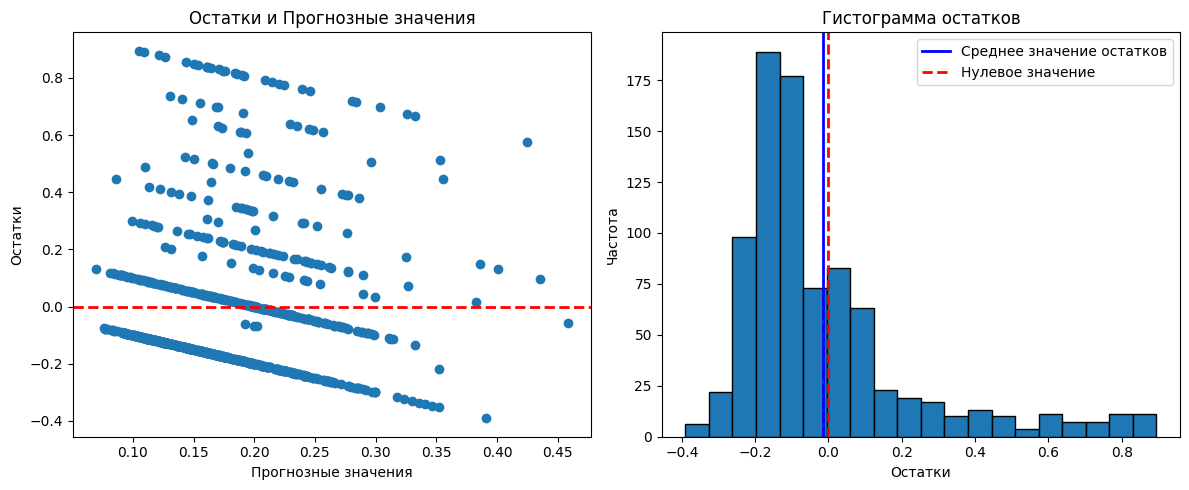

In [71]:
res_graph(y_test, y_pred)

## Тестирование работы лучшей модели

In [72]:
def search_image_by_text(query, model, df_with_image_embeddings, image_dir):
    """
    Принимает текстовый запрос, формирует BERT-эмбеддинг, сравнивает с изображениями,
    предсказывает степень соответствия и выводит наиболее релевантную картинку.
    """
    # 1. Проверка на чувствительный контент
    if pd.Series([query]).str.contains('child|kid|baby|babies|boy|girl', case=False, na=False).any():
        print("⚠️ This image is unavailable in your country in compliance with local laws.")
        return

    # 2. Получаем эмбеддинг текста через BERT
    text_embedding_df = get_bert_text_embeddings(query, batch_size=1)
    text_vector = text_embedding_df.drop(columns='index').values[0].reshape(1, -1)  # (1, 768)

    # 3. Извлекаем эмбеддинги изображений
    img_feat_cols = [col for col in df_with_image_embeddings.columns if col.startswith('img_feat_')]
    image_vectors = df_with_image_embeddings[img_feat_cols].values  # (N, 2048)

    # 4. Дублируем текстовый вектор под каждую картинку
    text_matrix = np.tile(text_vector, (image_vectors.shape[0], 1))  # (N, 768)

    # 5. Объединяем текст + картинка
    X_test = np.hstack([text_matrix, image_vectors])  # (N, 768+2048)

    # 6. Предсказания модели
    preds = model.predict(X_test)

    # 7. Находим наилучшее изображение
    idx = preds.argmax()
    best_image_name = df_with_image_embeddings.iloc[idx]['image']
    best_score = preds[idx]

    # 8. Путь и визуализация
    img_path = os.path.join(image_dir, best_image_name)
    print(f"📌 Запрос: {query}")
    print(f"🖼️ Лучшее изображение: {best_image_name}")
    print(f"🎯 Предсказанный score: {best_score:.4f}")

    plt.imshow(Image.open(img_path))
    plt.axis('off')
    plt.title("🔍 Наиболее релевантное изображение")
    plt.show()


In [73]:
# 1. Уникальные имена изображений из тестового датафрейма
test_image_names = test['image'].unique()

# 2. Извлекаем эмбеддинги изображений через ResNet-50
df_img_emb_test = extract_embeddings_resnet50_safe(
    image_names=test_image_names,
    image_dir='test_images',
    batch_size=64
)

# 3. Объединяем эмбеддинги с исходным test по колонке 'image'
df_test_with_embeddings = test.merge(df_img_emb_test, on='image', how='left')

# 4. Проверим
print(f"✅ Итоговый датафрейм: {df_test_with_embeddings.shape}")
df_test_with_embeddings[[ 'image', 'query_text'] + [col for col in df_test_with_embeddings.columns if col.startswith('img_feat_')][:3]].head()


📦 Старт: извлекаем эмбеддинги ResNet-50 для 100 изображений...


🔄 Извлечение эмбеддингов:   0%|          | 0/2 [00:00<?, ?it/s]

✅ Готово! 100 изображений обработано за 3.8 сек.
✅ Итоговый датафрейм: (500, 2052)


,image,query_text,img_feat_0,img_feat_1,img_feat_2
0,1177994172_10d143cb8d.jpg,"Two blonde boys , one in a camouflage shirt an...",0.222913,0.0,0.0
1,1177994172_10d143cb8d.jpg,Two boys are squirting water guns at each other .,0.222913,0.0,0.0
2,1177994172_10d143cb8d.jpg,Two boys spraying each other with water,0.222913,0.0,0.0
3,1177994172_10d143cb8d.jpg,Two children wearing jeans squirt water at eac...,0.222913,0.0,0.0
4,1177994172_10d143cb8d.jpg,Two young boys are squirting water at each oth...,0.222913,0.0,0.0


🔌 Используется устройство: cuda


🚀 Обработка BERT батчей:   0%|          | 0/1 [00:00<?, ?it/s]

C:\anaconda\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\anaconda\envs\practicum\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


📌 Запрос: A man is crossing a mountain pass on a metal bridge.
🖼️ Лучшее изображение: 3514297698_0512623955.jpg
🎯 Предсказанный score: 0.3192


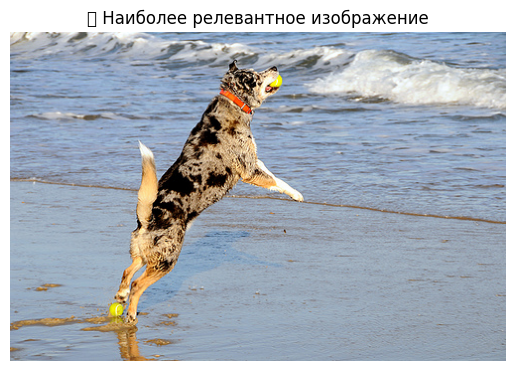

In [74]:
search_image_by_text(
    query="A man is crossing a mountain pass on a metal bridge.",
    model=best_model_object,
    df_with_image_embeddings=df_test_with_embeddings,
    image_dir='test_images'
)

## Выводы по проекту

1. Лучшей моделью оказалась 

In [75]:
print(f"\n🏆 Лучшая модель: {best_model_name}")
print(f"📉 Минимальный RMSE: {best_result['rmse']:.4f}")
print(f"📉 RMSE на тесте: {rmse_test:.4f}")
print(f"📈 R² на тесте: {r2_test:.4f}")


🏆 Лучшая модель: RandomForest
📉 Минимальный RMSE: 0.2458
📉 RMSE на тесте: 0.2458
📈 R² на тесте: 0.0504


2. RMSE высокая и R2 низкая - модель получилась слабая

3. Об этом говорит и рсапределение остатков - в них видны закономерности

4. Пути улучшения модели - значительно увеличить тренировочную выборку x10, x100. Может имеет смысл применить и дообучить трансформер.